In [1]:
%load_ext autoreload
%autoreload

In [2]:
from utils_v1 import *


In [3]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import sys
import numpy as np
from src.dataset import (
    MultipleDates,
    PAMultipleDates,
    MTMultipleDates,
    MAMultipleDates,
    MSMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates
from src.manager.multioutput import ManagerMCDropout, ManagerSingleRun, ManagerEnsemble
from src.Logger import Logger


c:\Users\jchamorro\anaconda3\envs\torch2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
ic.configureOutput(includeContext=True)

In [5]:
useLessInferenceRuns = False
reducedInferenceRuns = 30

In [6]:
config = {
	"training": True,
	"inferring": True,
	"site": "PA",
	"training_date": "current", # values: earlier, current
	"mode": "single_run", # values: mcd, single_run, ensemble
	"uncertainty_method": "pred_entropy_single", # pred_var MI pred_entropy KL pred_entropy_single
	"loadInference": False,
	"removePolygons": True,
	"plotLandsat": False,
	"plotPOI": False,
 

	"save_probabilities": False,
	"addPastDeforestationInput": True,
	"classes_mode": False,
	"learning_rate": 1e-4,
    "use_cloud_mask": False,
    
	"General": {
		"device": "cuda",
		"model_type": "deeplab",
		"optim": "adam",
		"lr": 1e-4,
		"momentum": 0.9,
		"batch_size": 32,
		"epochs": 100,
		"input_bands": 21,
		"path_model": "models",
		"exp_id": 0
		
	},
    "Dataset": {
        "patch_size": 128,
        "class_n": 3,
		"transforms":{
            "resize":224,
            "p_flip":0.5,
            "p_crop":0.3,
            "p_rot":0.2
		}
  	},
	"Train": {
        "lr": 1e-4,
        "batch_size": 32,
        "epochs": 100,
        "input_bands": 21,
        "transforms": {
            "resize": 224
        }    
    }  
}

In [7]:



if config['mode'] == 'mcd':
	managerClass = ManagerMCDropout
	config['inference_times'] = 10
	config['training_times'] = 1
elif config['mode'] == 'single_run':
	managerClass = ManagerSingleRun
	config['inference_times'] = 1
	config['training_times'] = 1
	config['uncertainty_method'] = 'pred_entropy_single'
elif config['mode'] == 'ensemble':
	managerClass = ManagerEnsemble
	config['inference_times'] = 10
	config['training_times'] = 10
else:
	raise ValueError('Invalid mode')

print(config)

if config['site'] == 'PA':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2017, 2018]
	else:
		dates = [2018, 2019]

	dataset = PAMultipleDates(config = config,
			   dates = dates, 
		addPastDeforestationInput = config['addPastDeforestationInput'],
		borderBuffer = 2)	
elif config['site'] == 'MT':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2018, 2019]
	else:
		dates = [2019, 2020]

	dataset = MTMultipleDates(config = config,
			   dates = dates, 
	 	addPastDeforestationInput = config['addPastDeforestationInput'],
		borderBuffer = 2)	
elif config['site'] == 'MS':
	dates = [2019, 2020]
	dataset = MSMultipleDates(config = config,
			   dates = dates, 
	 	addPastDeforestationInput = config['addPastDeforestationInput'],
		borderBuffer = 2)		
else:
	raise ValueError('Invalid site')

if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)
else:
	patchesHandler = PatchesHandler()



if config['training'] == False:

	if type(dataset) == PAMultipleDates:


		if config['training_date'] == 'current': exp = 10; repetition_id = 0
		elif config['training_date'] == 'earlier': exp = 1; repetition_id = 7
		 
	elif type(dataset) == MTMultipleDates:
		
		if config['training_date'] == 'current': exp = 2; repetition_id = 8
		elif config['training_date'] == 'earlier': exp = 3; repetition_id = 6		

	elif type(dataset) == MSMultipleDates:

		if config['training_date'] == 'current': exp = 0; repetition_id = 0
		elif config['training_date'] == 'earlier': exp = 1; repetition_id = 0		

else:

	exp = 10
	repetition_id = 0
	
logger = Logger()
manager = managerClass(config, dataset, patchesHandler, logger)
manager.defineExperiment(exp)


{'training': True, 'inferring': True, 'site': 'PA', 'training_date': 'current', 'mode': 'single_run', 'uncertainty_method': 'pred_entropy_single', 'loadInference': False, 'removePolygons': True, 'plotLandsat': False, 'plotPOI': False, 'save_probabilities': False, 'addPastDeforestationInput': True, 'classes_mode': False, 'learning_rate': 0.0001, 'use_cloud_mask': False, 'General': {'device': 'cuda', 'model_type': 'deeplab', 'optim': 'adam', 'lr': 0.0001, 'momentum': 0.9, 'batch_size': 32, 'epochs': 100, 'input_bands': 21, 'path_model': 'models', 'exp_id': 0}, 'Dataset': {'patch_size': 128, 'class_n': 3, 'transforms': {'resize': 224, 'p_flip': 0.5, 'p_crop': 0.3, 'p_rot': 0.2}}, 'Train': {'lr': 0.0001, 'batch_size': 32, 'epochs': 100, 'input_bands': 21, 'transforms': {'resize': 224}}, 'inference_times': 1, 'training_times': 1}


ic| dataset.py:337 in __init__()- list(self.date_ids): [0]
ic| dataset.py:358 in __init__()
    self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| patchesHandler.py:128 in __init__()- self.input_image_shape: 21
ic| patchesHandler.py:129 in __init__()
    self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [8]:
manager.config

{'training': True,
 'inferring': True,
 'site': 'PA',
 'training_date': 'current',
 'mode': 'single_run',
 'uncertainty_method': 'pred_entropy_single',
 'loadInference': False,
 'removePolygons': True,
 'plotLandsat': False,
 'plotPOI': False,
 'save_probabilities': False,
 'addPastDeforestationInput': True,
 'classes_mode': False,
 'learning_rate': 0.0001,
 'use_cloud_mask': False,
 'General': {'device': 'cuda',
  'model_type': 'deeplab',
  'optim': 'adam',
  'lr': 0.0001,
  'momentum': 0.9,
  'batch_size': 32,
  'epochs': 100,
  'input_bands': 21,
  'path_model': 'models',
  'exp_id': 0},
 'Dataset': {'patch_size': 128,
  'class_n': 3,
  'transforms': {'resize': 224, 'p_flip': 0.5, 'p_crop': 0.3, 'p_rot': 0.2}},
 'Train': {'lr': 0.0001,
  'batch_size': 32,
  'epochs': 100,
  'input_bands': 21,
  'transforms': {'resize': 224}},
 'inference_times': 1,
 'training_times': 1,
 'dropout_training': False}

In [9]:
exp

10

In [10]:
manager.setExperimentPath()
manager.createLogFolders()

In [11]:
# ic(type(dataset), exp, dataset.dates)


In [12]:

manager.loadLabel()

C:/Users/jchamorro/Documents/jorge/datasets/deforestation/PA/deforestation_past_years.tif
Loaded deforestation past years


ic| dataset.py:453 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| dataset.py:456 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| dataset.py:460 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
C:/Users/jchamorro/Documents/jorge/datasets/deforestation/PA/deforestation_before_2008_PA.tif


ic| dataset.py:464 in loadLabelFromDate()
    np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| dataset.py:466 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| dataset.py:445 in loadLabel()
    label_per_date.shape: (17730, 9203, 1)


Removing bufer................
Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]


In [13]:

# Creating tile mask
manager.createTrainValTestTiles()


Tiles size:  3546 2300
Mask size:  (17730, 9200)


In [14]:

manager.label_mask.dtype

dtype('uint8')

In [15]:

manager.getLabelCurrentDeforestation()

In [16]:

manager.loadInputImage()

ic| dataset.py:387 in loadInputImage()
    image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)


In [17]:

np.unique(manager.image_stack[...,0], return_counts=True)

(array([0.        , 0.08333334, 0.16666667, 0.25      , 0.33333334,
        0.4166667 , 0.5       , 0.5833334 , 0.6666667 , 0.75      ,
        0.8333334 , 0.9166667 , 1.        ], dtype=float32),
 array([104050616,   2209014,    644713,    968315,   1458862,   1560879,
          2477424,   1299508,    903419,    864429,   4570932,   3150455,
         38957434], dtype=int64))

In [18]:
if config['site'] == 'MS':
    manager.maskNoDataAsNotConsideredClass()

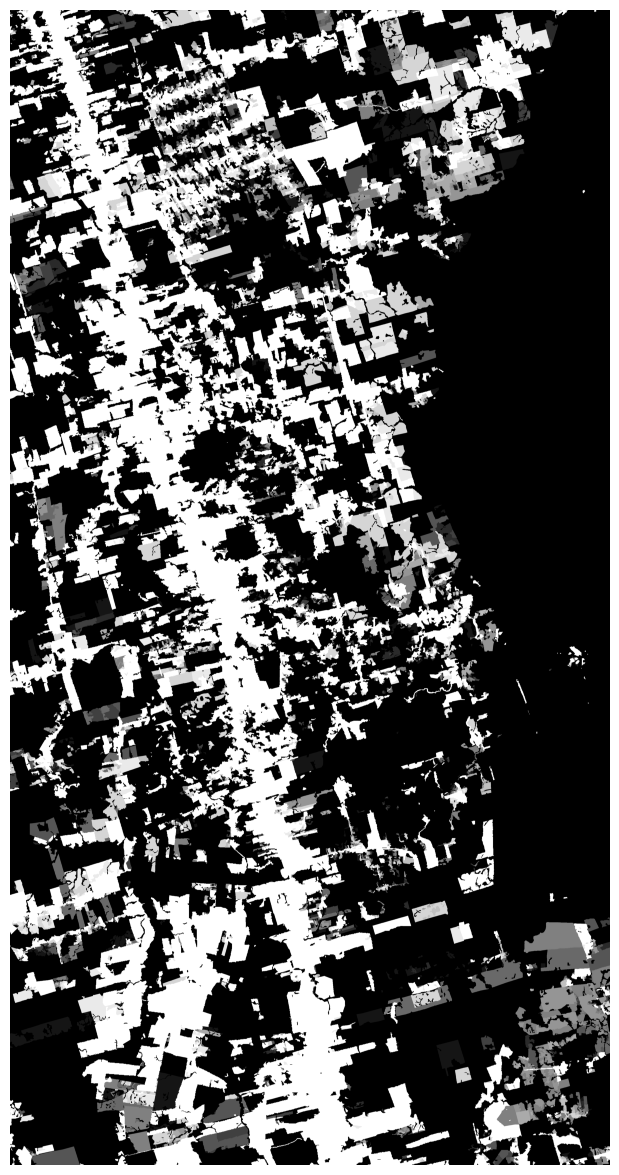

In [19]:

manager.logger.plotFigure(manager.image_stack[...,0], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False)

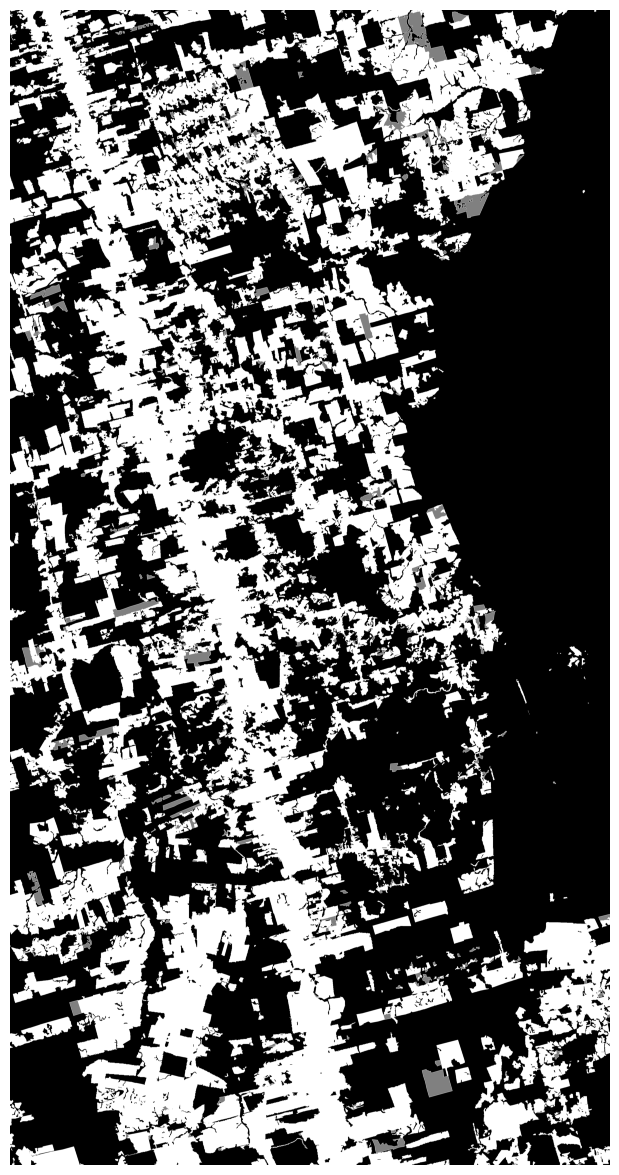

In [20]:

manager.logger.plotFigure(manager.label_mask, 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False)

In [21]:

manager.getImageChannels()

ic| base.py:99 in getImageChannels()
    self.image_stack.shape: (17730, 9200, 21)
ic| base.py:101 in getImageChannels()- self.channels: 21


In [22]:

manager.getTrainValTestMasks()

Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [23]:

if config["training"] == True:
    # Extracting patches from the idx matrix
    manager.createIdxImage()


ic| patchesHandler.py:24 in create_idx_image()
    im_idx_row.shape: (17730, 9200, 1)
    im_idx_col.shape: (17730, 9200, 1)
ic| patchesHandler.py:25 in create_idx_image()
    im_idx_row.dtype: dtype('uint16')
    im_idx_col.dtype: dtype('uint16')
ic| patchesHandler.py:31 in create_idx_image()
    im_idx.shape: (17730, 9200, 2)
    im_idx.dtype: dtype('uint16')


In [24]:
if config["training"] == True:
    manager.extractCoords()

ic| patchesHandler.py:43 in extract_patches()
    coords.shape: (464, 239, 1, 128, 128, 2)
    coords.dtype: dtype('uint16')
ic| patchesHandler.py:47 in extract_patches()
    coords.shape: (110896, 2)
    coords.dtype: dtype('uint16')


In [25]:
if config["training"] == True:
    manager.trainTestSplit()

ic| base.py:117 in trainTestSplit()
    self.coords_train.shape: (41812, 3)
    self.coords_val.shape: (10260, 3)


In [26]:
if config["training"] == True:
    manager.label_mask.shape

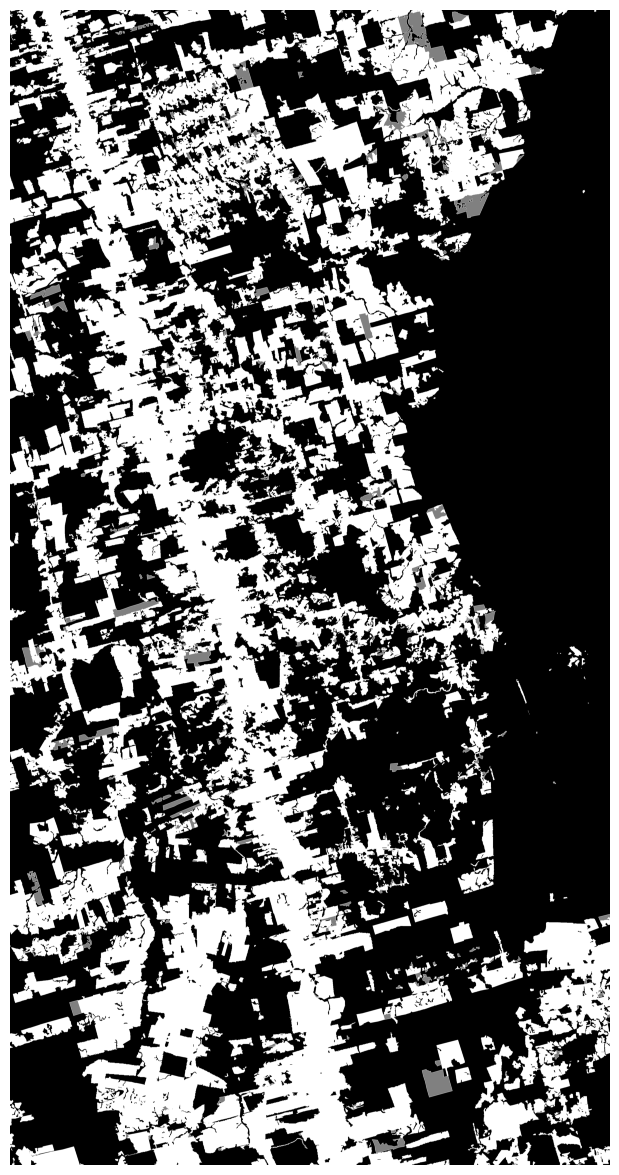

In [27]:
if config["training"] == True:

    manager.logger.plotFigure(manager.label_mask[...,-1], 
        name='Reference', cmap=plt.cm.gray, savefig=False)



In [28]:
if config["training"] == True:
    np.unique(manager.label_mask)

In [29]:
if config["training"] == True:
    print(manager.coords_train)

[[    0     0     0]
 [    0    38     0]
 [    0    76     0]
 ...
 [17594  8968     0]
 [17594  9006     0]
 [17594  9044     0]]


In [30]:
if config["training"] == True:
    manager.retrieveSamplesOfInterest()

training samples:  (3756, 3) validation samples:  (1032, 3)


In [31]:
if config["training"] == True:
    inputSnipShow = True

In [32]:
# count, unique = np.unique(label_mask, return_counts=True)
# print(count, unique)
# print(unique[1]/unique[0])

In [33]:
'''
count, unique = np.unique(label_mask[mask_amazon_ts == 1], return_counts=True)
print(count, unique)
print(unique[1]/unique[0])
'''

'\ncount, unique = np.unique(label_mask[mask_amazon_ts == 1], return_counts=True)\nprint(count, unique)\nprint(unique[1]/unique[0])\n'

In [34]:
'''
count, unique = np.unique(label_mask[mask_tr_val == 1], return_counts=True)
print(count, unique)
print(unique[1]/unique[0])
'''

'\ncount, unique = np.unique(label_mask[mask_tr_val == 1], return_counts=True)\nprint(count, unique)\nprint(unique[1]/unique[0])\n'

In [35]:
manager.dataset.image_channels

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]

In [36]:
manager.dataset.bands

10

ic| Logger.py:38 in snipDataset()
    np.mean(image_patch[...,dataset.previewBandsSnip[0]]): 0.29747355
    np.mean(image_patch[...,dataset.previewBandsSnip[1]]): 0.3196338


[2280 4750    0]
coord [2280 4750    0]
image_patch.shape (17730, 9200, 1)
reference_patch.shape (17730, 9200, 21)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


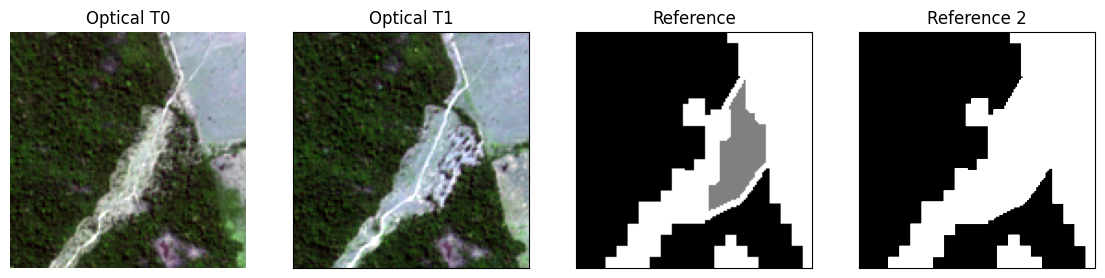

In [37]:
if config["training"] == True:
    if inputSnipShow == True:
        manager.snipDataset(idx = 1000)


ic| Logger.py:38 in snipDataset()
    np.mean(image_patch[...,dataset.previewBandsSnip[0]]): 0.2714837
    np.mean(image_patch[...,dataset.previewBandsSnip[1]]): 0.30292988
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 114 5928    0]
coord [ 114 5928    0]
image_patch.shape (17730, 9200, 1)
reference_patch.shape (17730, 9200, 21)


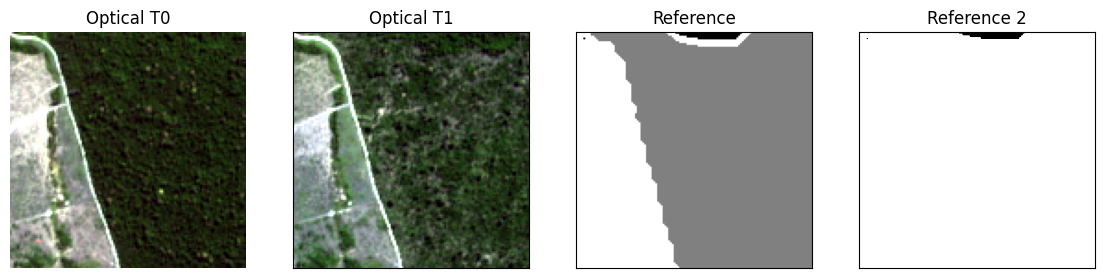

In [38]:
if config["training"] == True:
    if inputSnipShow == True:
        manager.snipDataset(idx = 97)


ic| Logger.py:38 in snipDataset()
    np.mean(image_patch[...,dataset.previewBandsSnip[0]]): 0.44512972
    np.mean(image_patch[...,dataset.previewBandsSnip[1]]): 0.45241854
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 874 1026    0]
coord [ 874 1026    0]
image_patch.shape (17730, 9200, 1)
reference_patch.shape (17730, 9200, 21)


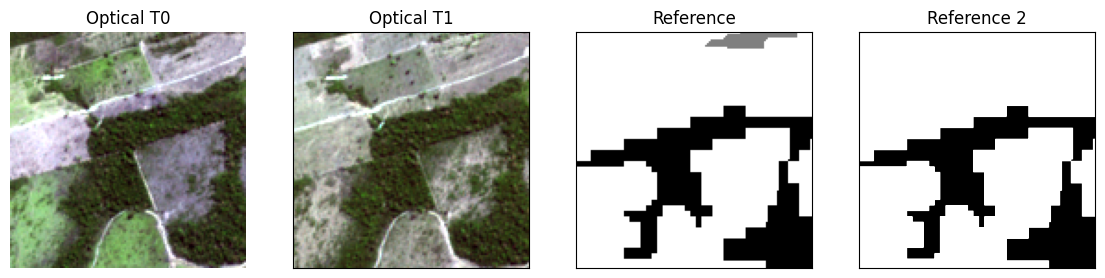

In [39]:
if config["training"] == True:
    if inputSnipShow == True:

        manager.snipDataset(idx = 500)

ic| Logger.py:38 in snipDataset()
    np.mean(image_patch[...,dataset.previewBandsSnip[0]]): 0.09604081
    np.mean(image_patch[...,dataset.previewBandsSnip[1]]): 0.23388559


[ 608 6574    0]
coord [ 608 6574    0]
image_patch.shape (17730, 9200, 1)
reference_patch.shape (17730, 9200, 21)


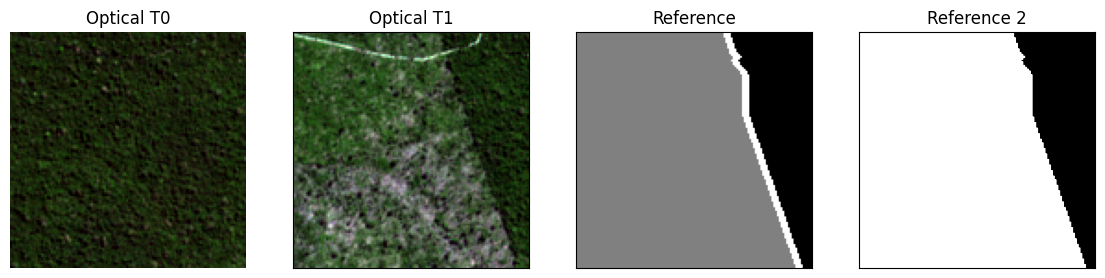

In [40]:
if config["training"] == True:
    if inputSnipShow == True:

        manager.snipDataset(idx = 400)

In [41]:
if config["training"] == True:
    manager.getGenerators()


In [42]:
if config["training"] == True:
    manager.fixChannelNumber()

In [43]:
if config["training"] == True:
    print(manager.path_exp)

C:/Users/jchamorro/Documents/jorge/deforestation_experiments/exp10


In [44]:
if config["training"] == True:
    print(manager.channels)

21


In [45]:
if config["training"] == True:
    print(manager.image_stack.shape)

(17730, 9200, 21)


In [46]:
if config["training"] == True:
    print("config['training_times']", config["training_times"])

config['training_times'] 1


In [47]:
if config["training"] == True:
    for tm in range(config['training_times']):
        manager.repetition_id = tm
        manager.train()

device: cuda
Epoch  1


Validation: 100%|██████████| 33/33 [00:02<00:00, 11.03it/s, validation_loss=0.98] 


Model saved at : models\DeepLabV3Plus_0
Epoch  2


Validation: 100%|██████████| 33/33 [00:02<00:00, 11.34it/s, validation_loss=0.368]


Model saved at : models\DeepLabV3Plus_0
Epoch  3


Validation: 100%|██████████| 33/33 [00:02<00:00, 11.22it/s, validation_loss=0.958]


Epoch  4


Validation: 100%|██████████| 33/33 [00:02<00:00, 11.06it/s, validation_loss=0.521]


Epoch  5


Validation: 100%|██████████| 33/33 [00:02<00:00, 11.41it/s, validation_loss=0.739]


Epoch  6


Validation: 100%|██████████| 33/33 [00:02<00:00, 11.29it/s, validation_loss=0.573]


Epoch  7


Validation: 100%|██████████| 33/33 [00:02<00:00, 11.23it/s, validation_loss=0.553]


Epoch  8


Validation: 100%|██████████| 33/33 [00:02<00:00, 11.40it/s, validation_loss=0.541]


Epoch  9


Validation: 100%|██████████| 33/33 [00:02<00:00, 11.19it/s, validation_loss=0.407]


Epoch  10


Validation: 100%|██████████| 33/33 [00:02<00:00, 11.20it/s, validation_loss=0.29] 


Model saved at : models\DeepLabV3Plus_0
Epoch  11


Validation: 100%|██████████| 33/33 [00:02<00:00, 11.08it/s, validation_loss=0.206]


Model saved at : models\DeepLabV3Plus_0
Epoch  12


Validation: 100%|██████████| 33/33 [00:02<00:00, 11.06it/s, validation_loss=0.249]


Epoch  13


Validation: 100%|██████████| 33/33 [00:02<00:00, 11.11it/s, validation_loss=0.256]


Epoch  14


Validation: 100%|██████████| 33/33 [00:02<00:00, 11.04it/s, validation_loss=0.221]


Epoch  15


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.41it/s, validation_loss=0.218]


Epoch  16


Validation: 100%|██████████| 33/33 [00:02<00:00, 11.15it/s, validation_loss=0.403]


Epoch  17


Validation: 100%|██████████| 33/33 [00:02<00:00, 11.07it/s, validation_loss=0.322]


Epoch  18


Validation: 100%|██████████| 33/33 [00:02<00:00, 11.22it/s, validation_loss=0.214]


Epoch  19


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.99it/s, validation_loss=0.243]


Epoch  20


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.92it/s, validation_loss=0.31] 


Epoch  21


Validation: 100%|██████████| 33/33 [00:02<00:00, 11.01it/s, validation_loss=0.199]


Model saved at : models\DeepLabV3Plus_0
Epoch  22


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.95it/s, validation_loss=0.242]


Epoch  23


Validation: 100%|██████████| 33/33 [00:02<00:00, 11.03it/s, validation_loss=0.26] 


Epoch  24


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.14it/s, validation_loss=0.273]


Epoch  25


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.74it/s, validation_loss=0.361]


Epoch  26


Validation: 100%|██████████| 33/33 [00:02<00:00, 11.00it/s, validation_loss=0.256]


Epoch  27


Validation: 100%|██████████| 33/33 [00:02<00:00, 11.07it/s, validation_loss=0.253]


Epoch  28


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.76it/s, validation_loss=0.209]


Epoch  29


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.90it/s, validation_loss=0.252]


Epoch  30


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.91it/s, validation_loss=0.336]


Epoch  31


Validation: 100%|██████████| 33/33 [00:03<00:00, 10.85it/s, validation_loss=0.299]


Early stopping
10 10
Finished Training


NameError: name 'exit' is not defined

In [48]:
# if config["training"] == True:
#     manager.plotHistory()


AttributeError: 'ManagerSingleRun' object has no attribute 'history'

<Figure size 640x480 with 0 Axes>

In [ ]:
repetition_id = 0

In [ ]:
if config["inferring"] != True:
    sys.exit()
else:
    manager.repetition_id = repetition_id

In [ ]:
manager.image_stack.shape

(17730, 9200, 21)

In [ ]:
manager.patchesHandler.dataset.image_channels[-1]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [ ]:
if issubclass(type(dataset), MultipleDates):
	manager.channels = manager.patchesHandler.input_image_shape
	manager.image_stack = manager.image_stack[..., manager.patchesHandler.dataset.image_channels[-1]]
	manager.label_mask = manager.label_mask[...,-1]


In [ ]:
manager.image_stack.shape

(17730, 9200, 21)

In [ ]:
manager.setPadding()

-30.0 -16.0


In [ ]:
manager.infer()

ic| base.py:266 in infer()
    self.path_models+ '/' + self.method +'_'+str(self.repetition_id)+'.h5': 'C:/Users/jchamorro/Documents/jorge/deforestation_experiments/exp10/models/resunet_0.h5'


Dropout training mode: False
time:  0


In [ ]:
manager.loadPredictedProbabilities()

In [ ]:
manager.prob_rec.shape

(17760, 9216, 1)

In [ ]:
'''
if useLessInferenceRuns == True:
    ic(reducedInferenceRuns)

    prob_rec_all = prob_rec.copy()
    prob_rec = prob_rec_all[:reducedInferenceRuns]
    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))
'''

'\nif useLessInferenceRuns == True:\n    ic(reducedInferenceRuns)\n\n    prob_rec_all = prob_rec.copy()\n    prob_rec = prob_rec_all[:reducedInferenceRuns]\n    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))\n'

In [ ]:
manager.prob_rec.shape

(17760, 9216, 1)

In [ ]:
manager.getMeanProb()

In [ ]:
manager.logger.getStats(manager.mean_prob)

ic| Logger.py:119 in getStats()
    np.min(value): 1.0433917e-15
    np.mean(value): 0.015229148
    np.max(value): 0.99968207


In [ ]:
ic(manager.mean_prob.shape)

ic| 3681128488.py:1 in <cell line: 1>()
    trainer.mean_prob.shape: (17760, 9216)


(17760, 9216)

In [ ]:
manager.unpadMeanProb()

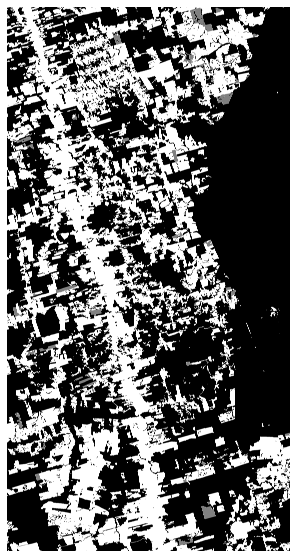

In [ ]:
manager.logger.plotFigure(manager.label_mask, 
            name='Reference mask', figsize=(10,10), cmap=plt.cm.gray, savefig=True)

In [ ]:
manager.squeezeLabel()

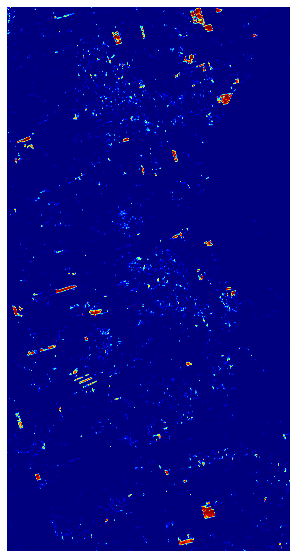

In [ ]:
manager.setMeanProbNotConsideredAreas()
manager.logger.plotFigure(manager.mean_prob, 
            name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

In [ ]:
print(manager.label_mask.shape)

(17730, 9200)


In [ ]:
manager.getLabelTest()

(54840627,)
(array([0, 1], dtype=uint8), array([54073429,   767198], dtype=int64))


In [ ]:
# manager.getMAP()

In [ ]:
manager.prob_rec.shape

(17760, 9216, 1)

In [ ]:
manager.preprocessProbRec()
print(manager.prob_rec.shape)

(1, 17760, 9216, 1)


In [ ]:
manager.prob_rec.shape

(1, 17760, 9216, 1)

In [ ]:
manager.logger.getStats(manager.prob_rec)

ic| Logger.py:119 in getStats()
    np.min(value): 1.0433917e-15
    np.mean(value): 0.015229148
    np.max(value): 0.99968207


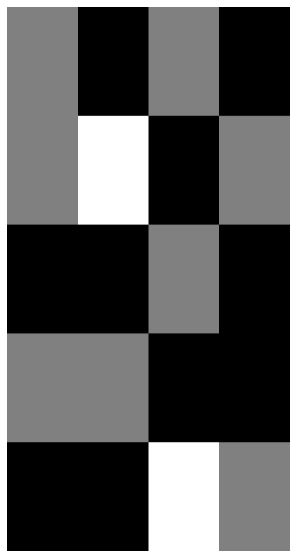

In [ ]:
manager.logger.plotFigure(manager.mask_tr_val, 
            name=manager.dataset.site + manager.title_name + ' Train val mask.png', figsize=(10,10), savefig=False)

In [ ]:
manager.getLabelCurrentDeforestation()

In [ ]:
manager.applyProbabilityThreshold()

(17730, 9200)
Single entropy
(array([0., 1.], dtype=float32), array([161127576,   1988424], dtype=int64))


ic| base.py:394 in applyProbabilityThreshold()
    self.predicted_unpad.shape: (17730, 9200)
    self.predicted.shape: (17730, 9200)


In [ ]:
manager.getTestValues()

ic| base.py:417 in getTestValues()- predicted_test.shape: (81558000,)
ic| base.py:426 in getTestValues()- predicted_test.shape: (54840627,)


In [ ]:
manager.removeSmallPolygons()

ic| metrics.py:213 in removeSmallPolygonsForMetrics()
    np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161212070,   1903930], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161438307,   1677693], dtype=int64))
ic| metrics.py:215 in removeSmallPolygonsForMetrics()
    np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([162889763,    226237], dtype=int64))


In [ ]:
manager.calculateMetrics()

ic| base.py:470 in calculateMetrics()
    self.f1: 83.98
    self.precision: 88.38
    self.recall: 80.01


In [ ]:
manager.getValidationValuesForMetrics()
manager.calculateMetricsValidation()

ic| base.py:399 in getValidationValuesForMetrics()
    self.label_mask_val.shape: (16311600,)
ic| base.py:405 in getValidationValuesForMetrics()
    self.label_mask_val_valid.shape: (9424148,)
ic| base.py:481 in calculateMetricsValidation()
    f1_val: 85.69
    precision_val: 82.97
    recall_val: 88.61
    mAP_val: 91.11


In [ ]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    manager.calculateMAPWithoutSmallPolygons()

In [ ]:
manager.get_label_no_buffer()

C:/Users/jchamorro/Documents/jorge/datasets/deforestation/PA/deforestation_past_years.tif
Loaded deforestation past years


ic| dataset.py:453 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| dataset.py:456 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| dataset.py:460 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
C:/Users/jchamorro/Documents/jorge/datasets/deforestation/PA/deforestation_before_2008_PA.tif


ic| dataset.py:464 in loadLabelFromDate()
    np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| dataset.py:466 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| dataset.py:445 in loadLabel()
    label_per_date.shape: (17730, 9203, 1)


In [ ]:
manager.getErrorMask()

(array([0., 1.], dtype=float32), array([162511457,    604543], dtype=int64))


In [ ]:
manager.getErrorMaskToShowRGB()

[0. 1.]


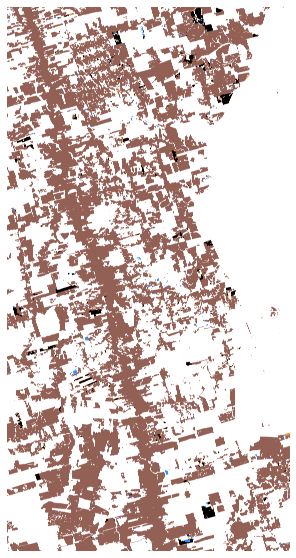

In [ ]:
manager.logger.plotFigure(manager.error_mask_to_show_rgb[...,::-1], 
            name=manager.dataset.site + manager.title_name + ' error mask color.png', 
            figsize=(10,10), savefig=True, dpi=300)

In [ ]:
'''
import types

manager.setUncertainty = types.MethodType(setUncertainty, manager)
'''


'\nimport types\n\ntrainer.setUncertainty = types.MethodType(setUncertainty, trainer)\n'

In [ ]:
manager.setUncertainty()

ic| uncertainty.py:49 in single_experiment_entropy()
    pred_entropy.shape: (17760, 9216)


In [ ]:
manager.uncertainty_map[manager.uncertainty_map>1] = 1

In [ ]:
manager.logger.getStats(manager.uncertainty_map)

ic| Logger.py:119 in getStats()
    np.min(value): 3.5291855e-14
    np.mean(value): 0.011901395
    np.max(value): 0.36787948


In [ ]:
manager.getUncertaintyToShow()
manager.logger.getStats(manager.uncertainty_to_show)


ic| Logger.py:119 in getStats()
    np.min(value): 0.0
    np.mean(value): 0.010473617
    np.max(value): 0.36787948


ic| 2250769769.py:4 in <cell line: 4>()
    trainer.uncertainty_to_show.shape: (17730, 9200)


(17730, 9200)

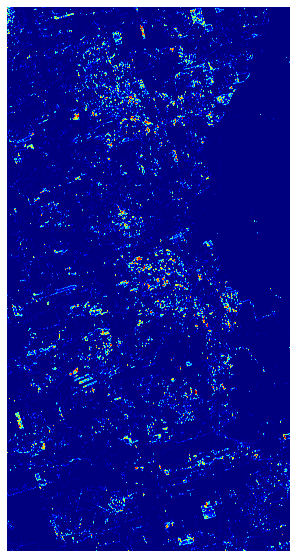

In [ ]:

manager.logger.plotFigure(manager.uncertainty_to_show, 
            name=manager.dataset.site + manager.title_name + ' uncertainty '+manager.config['uncertainty_method']+'.png', figsize=(10,10), cmap='jet', savefig=True)

ic(manager.uncertainty_to_show.shape)



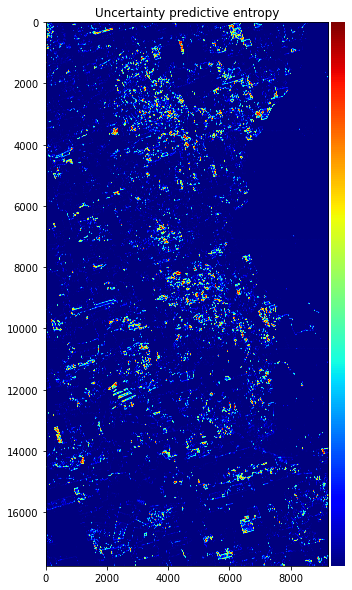

In [ ]:

import src.uncertainty
fig, ax = plt.subplots(1,1,figsize=(10,10))
src.uncertainty.show_im(manager.uncertainty_map, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('output/figures/Para' + manager.title_name + ' uncertainty '+manager.config['uncertainty_method']+'.png', 
    dpi=150, bbox_inches='tight')

In [ ]:
manager.getValidationValues2()
manager.getTestValues2()

ic| base.py:521 in getTestValues2()
    self.label_mask.shape: (17730, 9200)
ic| base.py:522 in getTestValues2()
    self.mask_amazon_ts.shape: (17730, 9200)
ic| base.py:526 in getTestValues2()
    self.label_mask_test.shape: (81558000,)
ic| base.py:534 in getTestValues2()
    self.error_mask_test.shape: (54734505,)


ic| Logger.py:163 in plotCropSample()
    trainer.dataset.previewLims1: array([2200, 3200, 6900, 7900])
    trainer.dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| Logger.py:165 in plotCropSample()
    np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| Logger.py:167 in plotCropSample()
    np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


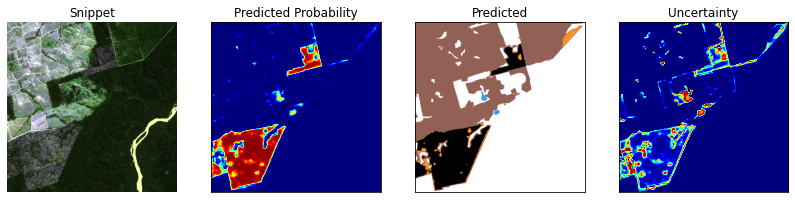

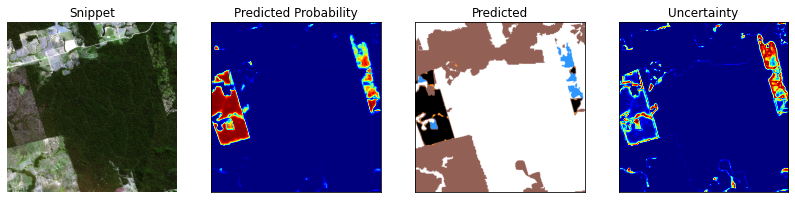

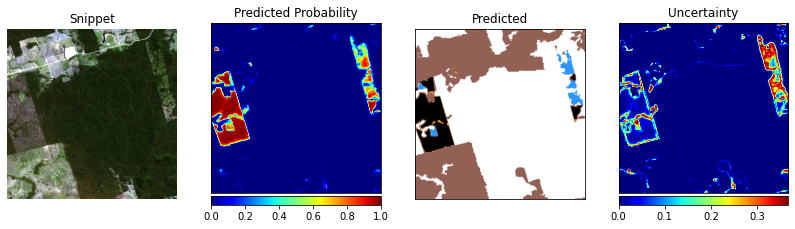

In [ ]:
manager.logger.plotCropSample(manager)

In [ ]:
if config["plotLandsat"] == True:
    label_tmp_dates = []
    for date in dataset.prodes_dates:
        label_tmp_date = dataset.loadLabelFromDate(date)
        label_tmp_date = label_tmp_date[:manager.mask_tiles.shape[0], :manager.mask_tiles.shape[1]]
        label_tmp_dates.append(label_tmp_date)

In [ ]:
if config["plotLandsat"] == True:
    # del manager.image_stack
    import src.lansdatLoader as ll
    import importlib
    importlib.reload(ll)
    landsatLoader = ll.LandsatLoader(dataset)
    ims = landsatLoader.load()
    for idx in range(len(ims)):
        ims[idx] = ims[idx][:manager.mask_tiles.shape[0], :manager.mask_tiles.shape[1],:]
    ims = landsatLoader.darken_past_deforestation(ims, manager.label_no_buffer)
    ims = landsatLoader.add_deforestation_edges_by_date(ims, label_tmp_dates[:])

In [ ]:
if config["plotLandsat"] == True:
    logger.plotCropSampleLandsat(manager, ims)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


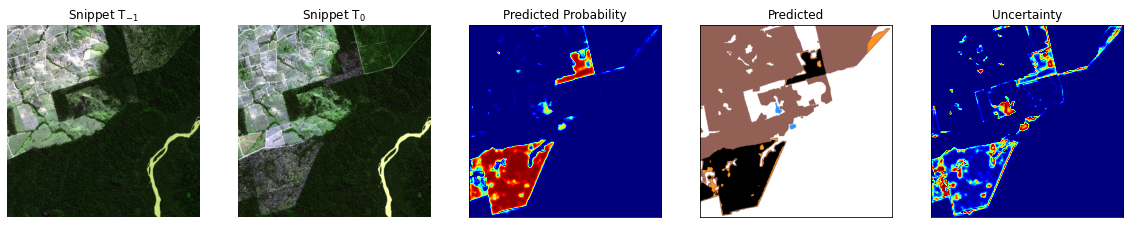

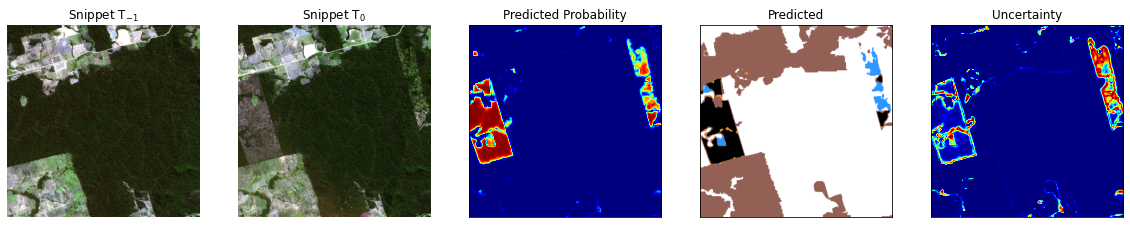

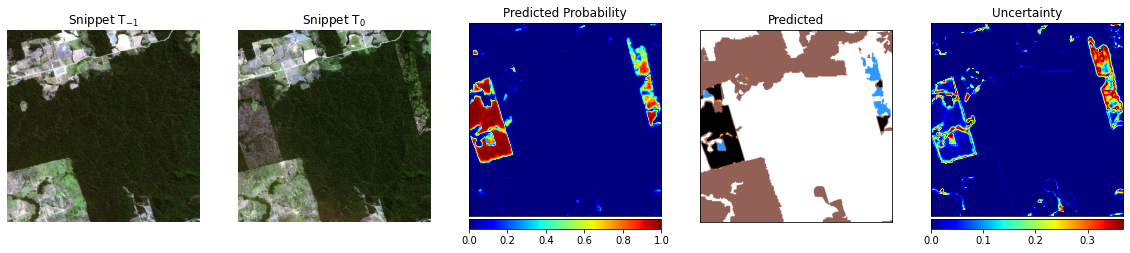

In [ ]:
manager.logger.plotCropSampleT0T1(manager)

In [ ]:
manager.logger.getStats(manager.uncertainty)


ic| Logger.py:119 in getStats()
    np.min(value): 3.5291855e-14
    np.mean(value): 0.01412716
    np.max(value): 0.36787948


In [ ]:
'''
manager.getOtherUncertaintyMetrics()
print(manager.sUEO)

print(manager.ece_score)  
'''

'\ntrainer.getOtherUncertaintyMetrics()\nprint(trainer.sUEO)\n\nprint(trainer.ece_score)  \n'

In [ ]:
if config["plotPOI"] == True and config['site'] == 'PA':

    print(manager.mean_prob.shape)
    font = {'family': "Times New Roman",
            'color':  'white',
            'weight': 'bold',
            'size': 24,
            }

    lims = dataset.previewLims1
    im = manager.uncertainty_map[lims[0]:lims[1], lims[2]:lims[3]]
    plt.figure(figsize=(10,10))
    plt.imshow(im, cmap='jet')

    letters = ['A', 'B', 'C', 'D', 'E', 'F']

    for poi_id in range(4):
            
            plt.text(manager.dataset.snippet_coords['snippet_id0'][poi_id][1], 
                    manager.dataset.snippet_coords['snippet_id0'][poi_id][0], 
                    letters[poi_id], fontdict=font)
    plt.axis('off')

    plt.savefig(os.path.join('output/pdf_plot_results', 
                            'pdf_plot_poi0.png'), 
    dpi=150, bbox_inches='tight')

    lims = dataset.previewLims2
    im = manager.uncertainty_map[lims[0]:lims[1], lims[2]:lims[3]]
    plt.figure(figsize=(10,10))
    plt.imshow(im, cmap='jet')

    letters = ['E', 'F']

    print(manager.dataset.snippet_coords['snippet_id1'])
    for poi_id in range(2):
            
            plt.text(manager.dataset.snippet_coords['snippet_id1'][poi_id][1], 
                    manager.dataset.snippet_coords['snippet_id1'][poi_id][0], 
                    letters[poi_id], fontdict=font)
    plt.axis('off')
            
    plt.savefig(os.path.join('output/pdf_plot_results', 
                            'pdf_plot_poi1.png'), 
    dpi=150, bbox_inches='tight')

In [ ]:
if config["plotPOI"] == True and config['site'] == 'PA':
    manager.getPOIValues()


In [ ]:

if config["plotPOI"] == True and config['site'] == 'PA':
    import pickle
    with open('output/log/log_ensemble_.pkl', 'wb') as f:
                pickle.dump(manager.snippet_poi_results, f)


In [ ]:
from src import metrics as _metrics

def getUncertaintyAAValues(self):



    # self.threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

    # self.threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003]
    if self.config['uncertainty_method'] == "pred_entropy_single":
        self.threshold_list = [0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                            0.25, 0.27, 0.3, 0.34, 0.36, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
    if self.config['uncertainty_method'] == "pred_entropy":
            if self.classes_mode == False:
                    self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                            0.25, 0.27, 0.3, 0.34, 0.36, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
                    # self.threshold_list = [0.0025, 0.025, 0.05, 0.1, 0.2, 0.4, 
                    #         0.5, 0.6, 0.7, 0.8, 0.9, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
            else:
                    self.threshold_list = [0.0025, 0.025, 0.05, 0.075, 0.1, 0.2, 0.4, 
                    0.5, 0.6, 0.7, 0.8, 0.9, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
                    
                    # self.threshold_list = [0.13, 0.15, 0.2, 0.225, 
                    # 0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]
    elif self.config['uncertainty_method'] == "pred_var":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*0.13/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.0015, np.max(self.uncertainty)-0.0008]
    elif self.config['uncertainty_method'] == "MI":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*0.235/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
    elif self.config['uncertainty_method'] == "KL":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*1.0/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.006, np.max(self.uncertainty)-0.003]
    elif self.config['uncertainty_method'] == "evidential":
            # self.threshold_list = [0.015, 0.03, 0.04]
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [ 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [ 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]

            self.threshold_list = [0.13, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]

            # self.threshold_list = [ 0.15, 0.2,  
            #          0.3, 0.35, 0.4, 0.5, 0.6, 0.7]

            # self.threshold_list = [0.015,0.1, 0.2, 0.27, 0.36, 0.45, 0.55, 0.65]

            # self.threshold_list = [x*1.0/0.36 for x in self.threshold_list] + [np.max(uncertainty)-0.006, np.max(uncertainty)-0.003]
                    
            # self.threshold_list = np.linspace(np.min(uncertainty) + 0.0015, np.max(uncertainty) - 0.0015, 19)
    print(self.threshold_list)
    self.loadThresholdMetrics = False
    if self.loadThresholdMetrics == False:
            # self.threshold_list = [0.1]
            # y_test
            ic(self.uncertainty.shape, self.label_mask_current_deforestation_test.shape)

            metrics_values = _metrics.getAA_Recall(self.uncertainty, 
                    self.label_mask_current_deforestation_test, 
                    self.predicted_test, self.threshold_list)

            # ic(metrics_values)


    self.m = {'precision_L': metrics_values[:,0],
            'recall_L': metrics_values[:,1],
            'recall_Ltotal': metrics_values[:,2],
            'AA': metrics_values[:,3],
            'precision_H': metrics_values[:,4],
            'recall_H': metrics_values[:,5],
            'UEO': metrics_values[:,6]}

    self.m['f1_L'] = 2*self.m['precision_L']*self.m['recall_L']/(self.m['precision_L']+self.m['recall_L'])
    self.m['f1_H'] = 2*self.m['precision_H']*self.m['recall_H']/(self.m['precision_H']+self.m['recall_H'])


In [ ]:

import types

manager.getUncertaintyAAValues = types.MethodType(getUncertaintyAAValues, manager)



Get precision-recall threshold

In [ ]:

manager.getUncertaintyAAValues()

ic| 810240186.py:62 in getUncertaintyAAValues()
    self.uncertainty.shape: (54734505,)
    self.label_mask_current_deforestation_test.shape: (54734505,)


[0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 0.25, 0.27, 0.3, 0.34, 0.36, 0.3648794801235199, 0.3663794801235199]
threshold 0.0075


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (6582141,)
    predicted_test_classified_incorrect.shape: (6582141,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 6582141
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 6582141
    len(label_mask_current_deforestation_test): 54734505


[1.         0.76292853 0.03219523 0.12025579 0.87952915 0.80168566
 0.03287708]
threshold 0.01


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (6144515,)
    predicted_test_classified_incorrect.shape: (6144515,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 6144515
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 6144515
    len(label_mask_current_deforestation_test): 54734505


[1.         0.85158997 0.06103252 0.11226036 0.8754139  0.79607116
 0.03513778]
threshold 0.015


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (5517187,)
    predicted_test_classified_incorrect.shape: (5517187,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 5517187
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 5517187
    len(label_mask_current_deforestation_test): 54734505


[1.         0.90816665 0.11572109 0.10079907 0.86678388 0.78426184
 0.0389804 ]
threshold 0.025


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (4725332,)
    predicted_test_classified_incorrect.shape: (4725332,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 4725332
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 4725332
    len(label_mask_current_deforestation_test): 54734505


[1.         0.93662323 0.19691207 0.08633187 0.85151386 0.76369419
 0.04523778]
threshold 0.05


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (3657709,)
    predicted_test_classified_incorrect.shape: (3657709,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 3657709
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 3657709
    len(label_mask_current_deforestation_test): 54734505


[0.99904569 0.95097939 0.31659456 0.06682638 0.82174529 0.72472774
 0.05770848]
threshold 0.08


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (2956115,)
    predicted_test_classified_incorrect.shape: (2956115,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2956115
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2956115
    len(label_mask_current_deforestation_test): 54734505


[0.99470551 0.95312906 0.39951014 0.05400825 0.79537216 0.6895832
 0.06998558]
threshold 0.1


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (2626927,)
    predicted_test_classified_incorrect.shape: (2626927,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2626927
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2626927
    len(label_mask_current_deforestation_test): 54734505


[0.9907756  0.95264186 0.44172738 0.04799398 0.78000575 0.66812209
 0.07741606]
threshold 0.15


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (2023623,)
    predicted_test_classified_incorrect.shape: (2023623,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2023623
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2023623
    len(label_mask_current_deforestation_test): 54734505


[0.9803889  0.94953174 0.53063955 0.03697161 0.74019874 0.6106915
 0.09526299]
threshold 0.2


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1575237,)
    predicted_test_classified_incorrect.shape: (1575237,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1575237
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1575237
    len(label_mask_current_deforestation_test): 54734505


[0.96973592 0.94397289 0.60629301 0.0287796  0.69196452 0.5416416
 0.11369614]
threshold 0.225


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1379266,)
    predicted_test_classified_incorrect.shape: (1379266,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1379266
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1379266
    len(label_mask_current_deforestation_test): 54734505


[0.96198832 0.94057836 0.64254908 0.0251992  0.66375985 0.49707223
 0.12295975]
threshold 0.25


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1193495,)
    predicted_test_classified_incorrect.shape: (1193495,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1193495
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1193495
    len(label_mask_current_deforestation_test): 54734505


[0.95221134 0.93667914 0.67774124 0.02180517 0.63218634 0.44243885
 0.13208641]
threshold 0.27


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1047169,)
    predicted_test_classified_incorrect.shape: (1047169,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1047169
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1047169
    len(label_mask_current_deforestation_test): 54734505


[0.94182518 0.93273485 0.70443028 0.01913179 0.60794741 0.39065344
 0.13861853]
threshold 0.3


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (827539,)
    predicted_test_classified_incorrect.shape: (827539,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 827539
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 827539
    len(label_mask_current_deforestation_test): 54734505


[0.9220639  0.92495736 0.74243275 0.01511915 0.57594945 0.29198048
 0.14567531]
threshold 0.34


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (504536,)
    predicted_test_classified_incorrect.shape: (504536,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 504536
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 504536
    len(label_mask_current_deforestation_test): 54734505


[0.88944431 0.90719348 0.79163965 0.00921788 0.55382131 0.06602926
 0.14508212]
threshold 0.36


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (255949,)
    predicted_test_classified_incorrect.shape: (255949,)
c:\Users\jchamorro\Documents\jorge\deforestation_uncertainty_torch\src\metrics.py:296: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 255949
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 255949
    len(label_mask_current_deforestation_test): 54734505


[0.88381381 0.85765355 0.80005013 0.00467619        nan 0.
 0.11449219]
threshold 0.3648794801235199


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (154569,)
    predicted_test_classified_incorrect.shape: (154569,)
c:\Users\jchamorro\Documents\jorge\deforestation_uncertainty_torch\src\metrics.py:296: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 154569
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 154569
    len(label_mask_current_deforestation_test): 54734505


[0.88381381 0.834055   0.80005013 0.00282398        nan 0.
 0.0858482 ]
threshold 0.3663794801235199


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (108533,)
    predicted_test_classified_incorrect.shape: (108533,)
c:\Users\jchamorro\Documents\jorge\deforestation_uncertainty_torch\src\metrics.py:296: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 108533
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 108533
    len(label_mask_current_deforestation_test): 54734505


[0.88381381 0.82376951 0.80005013 0.0019829         nan 0.
 0.06788103]


In [ ]:
manager.getUncertaintyAAAuditedValues()

ic| base.py:663 in getUncertaintyAAAuditedValues()
    self.uncertainty.shape: (54734505,)
    self.label_mask_current_deforestation_test.shape: (54734505,)


threshold 0.0075
(54734505,) (54734505,)
cm_audited [[54000421        0]
 [    7344   726740]]
[1.        0.9899957]
threshold 0.01
(54734505,) (54734505,)
cm_audited [[54000421        0]
 [    7808   726276]]
[1.         0.98936362]
threshold 0.015
(54734505,) (54734505,)
cm_audited [[54000421        0]
 [    8590   725494]]
[1.         0.98829834]
threshold 0.025
(54734505,) (54734505,)
cm_audited [[54000421        0]
 [    9781   724303]]
[1.         0.98667591]
threshold 0.05
(54734505,) (54734505,)
cm_audited [[54000199      222]
 [   11980   722104]]
[0.99969266 0.98368034]
threshold 0.08
(54734505,) (54734505,)
cm_audited [[53998860     1561]
 [   14422   719662]]
[0.99783562 0.98035375]
threshold 0.1
(54734505,) (54734505,)
cm_audited [[53997402     3019]
 [   16120   717964]]
[0.99581266 0.97804066]
threshold 0.15
(54734505,) (54734505,)
cm_audited [[53992629     7792]
 [   20704   713380]]
[0.98919537 0.97179614]
threshold 0.2
(54734505,) (54734505,)
cm_audited [[53986531    

ic| base.py:669 in getUncertaintyAAAuditedValues()
    metric_values_audited: array([[1.        , 0.9899957 ],
                                  [1.        , 0.98936362],
                                  [1.        , 0.98829834],
                                  [1.        , 0.98667591],
                                  [0.99969266, 0.98368034],
                                  [0.99783562, 0.98035375],
                                  [0.99581266, 0.97804066],
                                  [0.98919537, 0.97179614],
                                  [0.98074999, 0.96401502],
                                  [0.97421855, 0.95940655],
                                  [0.96557994, 0.95418372],
                                  [0.95616913, 0.94919927],
                                  [0.93740463, 0.93976575],
                                  [0.90328532, 0.91901472],
                                  [0.89183892, 0.86721411],
                                  [0.88882121, 0.

cm_audited [[53923214    77207]
 [  125643   608441]]
[0.88739557 0.82884384]


In [ ]:
manager.setPlotLimsForUncertaintyAA()

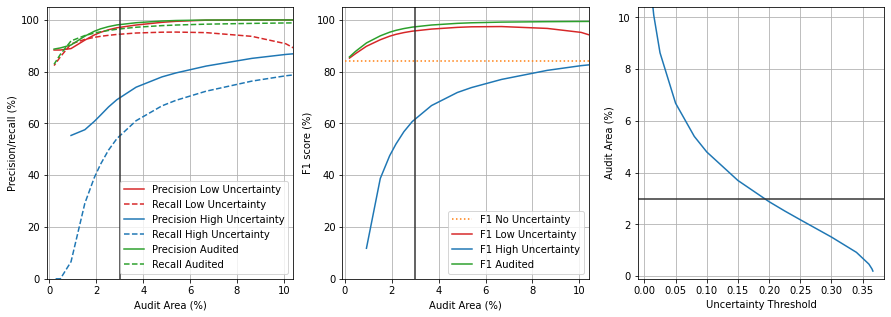

In [ ]:
'''
xlim = [-0.3, 12.7]
xlim = [-0.1, 10.4]

ylim = [0, 105]
'''
manager.plotUncertaintyAA(normalize_xlim=False)

In [ ]:
manager.getOptimalUncertaintyThreshold(bound = 0.0015)

ic| base.py:771 in getOptimalUncertaintyThreshold()
    bounds: (0.0015, 0.3663794801235199)
c:\Users\jchamorro\anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


0.1408715596097929
threshold 0.1408715596097929


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (2118500,)
    predicted_test_classified_incorrect.shape: (2118500,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2118500
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2118500
    len(label_mask_current_deforestation_test): 54734505


[0.98233377 0.95022465 0.5156903  0.03870502 0.7478031  0.62182821
 0.09199828]
0.22700792051372695
threshold 0.22700792051372695


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1363837,)
    predicted_test_classified_incorrect.shape: (1363837,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1363837
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1363837
    len(label_mask_current_deforestation_test): 54734505


[0.96130321 0.94029916 0.64551196 0.02491732 0.66118804 0.49293902
 0.123727  ]
0.28024311921958583
threshold 0.28024311921958583


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (972703,)
    predicted_test_classified_incorrect.shape: (972703,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 972703
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 972703
    len(label_mask_current_deforestation_test): 54734505


[0.93571528 0.93036812 0.71769307 0.01777129 0.59581744 0.36027913
 0.14152141]
0.20056324024068897
threshold 0.20056324024068897


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1570743,)
    predicted_test_classified_incorrect.shape: (1570743,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1570743
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1570743
    len(label_mask_current_deforestation_test): 54734505


[0.96959557 0.94388919 0.60709946 0.02869749 0.69136152 0.54076486
 0.11390128]
0.19072418202722466
threshold 0.19072418202722466


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1651208,)
    predicted_test_classified_incorrect.shape: (1651208,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1651208
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1651208
    len(label_mask_current_deforestation_test): 54734505


[0.97194956 0.94495325 0.59242948 0.03016759 0.70213805 0.55653498
 0.11017866]
0.17168217469208066
threshold 0.17168217469208066


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1816743,)
    predicted_test_classified_incorrect.shape: (1816743,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1816743
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1816743
    len(label_mask_current_deforestation_test): 54734505


[0.97602265 0.94720839 0.56399676 0.03319191 0.7210541  0.58346802
 0.10310386]
0.1895683607298039
threshold 0.1895683607298039


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1660874,)
    predicted_test_classified_incorrect.shape: (1660874,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1660874
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1660874
    len(label_mask_current_deforestation_test): 54734505


[0.97222179 0.94508962 0.59077435 0.03034419 0.7032805  0.55821576
 0.10974576]
0.1932788088534173
threshold 0.1932788088534173


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1630125,)
    predicted_test_classified_incorrect.shape: (1630125,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1630125
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1630125
    len(label_mask_current_deforestation_test): 54734505


[0.97132985 0.94470825 0.59623831 0.0297824  0.69945256 0.5525375
 0.11113761]
0.191699962646258
threshold 0.191699962646258


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1643317,)
    predicted_test_classified_incorrect.shape: (1643317,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1643317
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1643317
    len(label_mask_current_deforestation_test): 54734505


[0.97172396 0.94484735 0.5938394  0.03002342 0.70114591 0.55508049
 0.1105333 ]
0.191909134830978
threshold 0.191909134830978


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1641624,)
    predicted_test_classified_incorrect.shape: (1641624,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1641624
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1641624
    len(label_mask_current_deforestation_test): 54734505


[0.97165045 0.94482714 0.59416906 0.02999249 0.70094381 0.55473418
 0.11060173]
0.19243230375404202
threshold 0.19243230375404202


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1637163,)
    predicted_test_classified_incorrect.shape: (1637163,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1637163
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1637163
    len(label_mask_current_deforestation_test): 54734505


[0.97153185 0.94477252 0.5949687  0.02991099 0.70036193 0.55389704
 0.11080805]
0.1919424710107838
threshold 0.1919424710107838


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1641343,)
    predicted_test_classified_incorrect.shape: (1641343,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1641343
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1641343
    len(label_mask_current_deforestation_test): 54734505


[0.97164215 0.94482578 0.59422355 0.02998735 0.70090458 0.55467491
 0.11061495]
0.1918446327132674
threshold 0.1918446327132674


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1642142,)
    predicted_test_classified_incorrect.shape: (1642142,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1642142
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1642142
    len(label_mask_current_deforestation_test): 54734505


[0.97167169 0.94483046 0.59406689 0.03000195 0.7010088  0.55484451
 0.11057953]
0.19178937366482454
threshold 0.19178937366482454


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1642578,)
    predicted_test_classified_incorrect.shape: (1642578,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1642578
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1642578
    len(label_mask_current_deforestation_test): 54734505
ic| base.py:775 in getOptimalUncertaintyThreshold()
    self.threshold_optimal: 0.1918446327132674


[0.9717023  0.94484328 0.59397971 0.03000992 0.7010455  0.55492867
 0.11056803]


In [ ]:
manager.getUncertaintyMetricsFromOptimalThreshold()

threshold 0.1918446327132674


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1642142,)
    predicted_test_classified_incorrect.shape: (1642142,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1642142
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1642142
    len(label_mask_current_deforestation_test): 54734505


[0.97167169 0.94483046 0.59406689 0.03000195 0.7010088  0.55484451
 0.11057953]
threshold 0.1918446327132674
(54734505,) (54734505,)


ic| base.py:804 in getUncertaintyMetricsFromOptimalThreshold()
    self.m_optimal: {'AA': array([0.03000195]),
                     'UEO': array([0.11057953]),
                     'f1': 83.98,
                     'f1_H': array([0.61942088]),
                     'f1_L': array([0.95806311]),
                     'precision_H': array([0.7010088]),
                     'precision_L': array([0.97167169]),
                     'recall_H': array([0.55484451]),
                     'recall_L': array([0.94483046]),
                     'recall_Ltotal': array([0.59406689])}
ic| base.py:805 in getUncertaintyMetricsFromOptimalThreshold()
    self.m_audited_optimal: {'f1': array([0.97376836]),
                             'precision': array([0.98237432]),
                             'recall': array([0.96531187])}


cm_audited [[53987707    12714]
 [   25464   708620]]
[0.98237432 0.96531187]


{'metrics': {'precision_L': array([0.97167169]),
  'recall_L': array([0.94483046]),
  'recall_Ltotal': array([0.59406689]),
  'AA': array([0.03000195]),
  'precision_H': array([0.7010088]),
  'recall_H': array([0.55484451]),
  'UEO': array([0.11057953]),
  'f1_L': array([0.95806311]),
  'f1_H': array([0.61942088]),
  'f1': 83.98},
 'metrics_audited': {'precision': array([0.98237432]),
  'recall': array([0.96531187]),
  'f1': array([0.97376836])},
 'exp': 10}